In [1]:
import matplotlib.pyplot as plt
import numpy as np
import helper

import torch.nn as nn
import torchvision.models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
import torch
import pandas as pd
from torchinfo import summary
from PIL import Image
from torchvision.transforms import ToTensor
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
from copy import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
import math
from torcheval.metrics import BinaryAccuracy
import os
import torchmetrics
import timm
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
batch_size=4
image_count=25
tf = ToTensor()


In [2]:

class CustomDataset(Dataset):
    def __init__(self, image_list,sex,age,label):
        self.img_path=image_list
        
        self.label=label
        self.sex=sex
        self.age=age
    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        image_tensor=self.img_path[idx]
        clinical_tensor=self.sex[idx]
        clinical_age_tensor=self.age[idx]
        label_tensor=self.label[idx]
        return (image_tensor,clinical_tensor,clinical_age_tensor),label_tensor
    
train_image_transition_path='../../data/ensemble_tile/raw/train/transition/5x/*'
train_image_not_transition_path='../../data/ensemble_tile/raw/train/not_transition/5x/*'
test_image_transition_path='../../data/ensemble_tile/raw/test/transition/5x/*'
test_image_not_transition_path='../../data/ensemble_tile/raw/test/not_transition/5x/*'
train_image_list=[]
train_label_list=[]
test_image_list=[]
test_label_list=[]
train_image_transition_list=glob(train_image_transition_path)
train_image_transition_label=torch.ones(len(train_image_transition_list),1)
train_image_not_transition_list=glob(train_image_not_transition_path)
train_image_not_transition_label=torch.zeros(len(train_image_not_transition_list),1)
train_image_list.extend(train_image_transition_list)
train_image_list.extend(train_image_not_transition_list)
train_label_list.extend(train_image_transition_label)
train_label_list.extend(train_image_not_transition_label)
test_image_transition_list=glob(test_image_transition_path)
test_image_transition_label=torch.ones(len(test_image_transition_list),1)
test_image_not_transition_list=glob(test_image_not_transition_path)
test_image_not_transition_label=torch.zeros(len(test_image_not_transition_list),1)
test_image_list.extend(test_image_transition_list)
test_image_list.extend(test_image_not_transition_list)
test_label_list.extend(test_image_transition_label)
test_label_list.extend(test_image_not_transition_label)


train_image_5x_tensor=torch.empty((len(train_image_list),image_count,1,3,256,256))

test_image_5x_tensor=torch.empty((len(test_image_list),image_count,1,3,256,256))
train_csv=pd.read_csv('../../data/2023_dataton_age_sex_train.csv',encoding='cp949')
test_csv=pd.read_csv('../../data/2023_dataton_age_sex_validation.csv',encoding='cp949')
train_clinical_tensor=torch.zeros((len(train_image_list),2))
train_clinical_age_tensor=torch.zeros((len(train_image_list),1))
test_clinical_tensor=torch.zeros((len(test_image_list),2))
test_clinical_age_tensor=torch.zeros((len(test_image_list),1))
for i in tqdm(range(len(train_image_list))):
    image_file_list=glob(train_image_list[i]+'/*.jpg')
    image_index=torch.randint(low=0, high=len(image_file_list)-1,size=(image_count,))
    count=0
    for index in image_index:
        image=1-tf(Image.open(image_file_list[index]).resize((256,256))).unsqueeze(0)
        train_image_5x_tensor[i,count]=image.unsqueeze(0)
        count+=1
    
    clincal_feature=train_csv.loc[train_csv['데이터톤번호'] == os.path.basename(train_image_list[i])].reset_index()
    train_clinical_age_tensor[i,0]=clincal_feature.loc[0]['나이']/100
    if clincal_feature.loc[0]['성별']=='Female':
        train_clinical_tensor[i,1]=1
    else:
        train_clinical_tensor[i,0]=1

        
for i in tqdm(range(len(test_image_list))):
    image_file_list=glob(test_image_list[i]+'/*.jpg')
    image_index=torch.randint(low=0, high=len(image_file_list)-1,size=(image_count,))

    count=0
    for index in image_index:
        image=1-tf(Image.open(image_file_list[index]).resize((256,256))).unsqueeze(0)
        test_image_5x_tensor[i,count]=image.unsqueeze(0)
        count+=1
    clincal_feature=test_csv.loc[test_csv['데이터톤번호'] == os.path.basename(test_image_list[i])].reset_index()
    test_clinical_age_tensor[i,0]=clincal_feature.loc[0]['나이']/100
    if clincal_feature.loc[0]['성별']=='Female':
        test_clinical_tensor[i,1]=1
    else:
        test_clinical_tensor[i,0]=1  
      
    



  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

In [3]:
train_dataset=CustomDataset(train_image_5x_tensor,train_clinical_tensor,train_clinical_age_tensor,train_label_list)
test_dataset=CustomDataset(test_image_5x_tensor,test_clinical_tensor,test_clinical_age_tensor,test_label_list)
dataset_size = len(test_dataset)
test_size = int(dataset_size * 0.5)
validation_size = dataset_size-test_size
validation_dataset, test_dataset = random_split(test_dataset, [validation_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
class Custom_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1= timm.create_model('resnet50')
        self.hidden_size = 128
        self.num_layers = 4
        self.rnn = nn.RNN(1000, 128, 4, batch_first=True)
        self.fc = nn.Linear(128, 2)
        self.cfs=nn.Linear(2, 1000)
        self.cfa=nn.Linear(1, 1000)
        self.fc1=nn.Linear(1000, 256)
        self.relu1=nn.ReLU()
        self.relu2=nn.ReLU()
        self.fc2=nn.Linear(256, 64)
        self.fc3=nn.Linear(64, 1)
        self.optim=nn.Sigmoid()
        self.fc4=nn.Linear(5, 1)
        self.fc5=nn.Linear(4, 1)
    def forward(self, inputs,sex,age):
        total_x=torch.empty((batch_size,image_count,1)).to(device)
        final_x=torch.empty((batch_size,5,1)).to(device)
        for i in range(len(inputs)):
            for j in range(len(inputs[i])):
                x=self.cnn1(inputs[i,j].to(device))
                x=self.fc1(x).to(device)
                x=self.fc2(x).to(device)
                x=self.fc3(x).to(device)
                total_x[i,j]=x.to(device)
            total_x[i], indices=torch.sort(total_x[i], dim=1)
            final_x[i]=total_x[i,-5:].to(device)
        
        x=self.fc4(final_x.squeeze())
        x=torch.cat([x,sex],dim=1).to(device)
        x=torch.cat([x,age],dim=1).to(device)
        x=self.fc5(x)
        x=self.optim(x)
        return x
    
model = Custom_model()
model = model.to(device)
criterion = nn.BCELoss().to(device)
accuracy = torchmetrics.Accuracy(task="binary").to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
# summary(model,input_size=[(batch_size,image_count,1,3,224,224),(batch_size,2),(batch_size,1)])

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

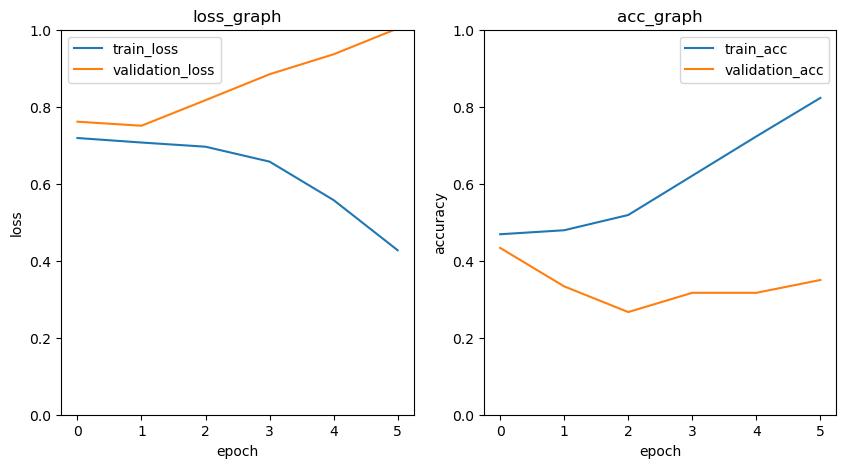

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:
MIN_loss=5000
train_loss_list=[]
val_loss_list=[]

train_acc_list=[]
sig=nn.Sigmoid()
val_acc_list=[]
for epoch in range(1000):
    train=tqdm(train_dataloader)
    count=0
    running_loss = 0.0
    acc_loss=0
    for x, y in train:
        model.train()
        y = y.to(device).float()
        count+=1
        x[0]=x[0].to(device).float()
        x[1]=x[1].to(device).float()
        x[2]=x[2].to(device).float()
        
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x[0],x[1],x[2]).to(device)
        cost = criterion(predict, y) # cost 구함
        acc=accuracy(predict, y)
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
        acc_loss+=acc
        train.set_description(f"epoch: {epoch+1}/{1000} Step: {count+1} loss : {running_loss/count:.4f} accuracy: {acc_loss/count:.4f}")
    train_loss_list.append((running_loss/count))
    train_acc_list.append((acc_loss/count).cpu().detach().numpy())
#validation
    val=tqdm(validation_dataloader)
    model.eval()
    count=0
    val_running_loss=0.0
    acc_loss=0
    with torch.no_grad():
        for x, y in val:
            y = y.to(device).float()
            count+=1
            x[0]=x[0].to(device).float()
            x[1]=x[1].to(device).float()
            x[2]=x[2].to(device).float()
       
            predict = model(x[0],x[1],x[2]).to(device)
            acc=accuracy(predict, y)
            cost = criterion(predict, y)
            val_running_loss+=cost.item()
            acc_loss+=acc
            val.set_description(f"Validation epoch: {epoch+1}/{1000} Step: {count+1} loss : {val_running_loss/count:.4f}  accuracy: {acc_loss/count:.4f}")
        val_loss_list.append((val_running_loss/count))
        val_acc_list.append((acc_loss/count).cpu().detach().numpy())
    if epoch%100==5:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
        
        
    if MIN_loss>(val_running_loss/count):
        torch.save(model.state_dict(), '../../model/image_5x/EffB0_tile50_RNN_callback.pt')
        MIN_loss=(val_running_loss/count)
torch.save(model.state_dict(), '../../model/image_5x/EffB0_tile50_RNN.pt')